# Vision Transformer (ViT) with object detection full model train

dataset: https://data.mendeley.com/datasets/ydrm75xywg/1

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import scipy.io
import shutil
import pandas as pd
from PIL import Image
import numpy as np

In [3]:
df = pd.read_csv('StenosisDetection/train_labels.csv', usecols=['filename','xmax','ymax','xmin', 'ymin'])

In [4]:
image_size = 224  
images, targets = [], []

top_left_x_collection = []
top_left_y_collection = []
bottom_right_x_collection = []
bottom_right_y_collection = [] 

In [5]:
for index, row in df.iterrows():
    image = keras.utils.load_img(
        'StenosisDetection/dataset/'+row['filename'],
    )

    (w, h) = image.size[:2]
    image = image.resize((224, 224))
    images.append(keras.utils.img_to_array(image))
    
    
    top_left_x, top_left_y = row['xmax'], row['ymax']
    bottom_right_x, bottom_right_y = row['xmin'], row['ymin']
    
    targets.append(
        (
            float(top_left_x) / w,
            float(top_left_y) / h,
            float(bottom_right_x) / w,
            float(bottom_right_y) / h,
        )
    )


In [6]:
(x_train), (y_train) = (
    np.asarray(images[: int(len(images) * 0.8)]),
    np.asarray(targets[: int(len(targets) * 0.8)]),
)
(x_test), (y_test) = (
    np.asarray(images[int(len(images) * 0.8) :]),
    np.asarray(targets[int(len(targets) * 0.8) :]),
)

In [7]:
len(images)

7493

In [8]:
len(targets)

7493

In [9]:
images[1]

array([[[253., 253., 253.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [252., 252., 252.],
        [238., 238., 238.],
        [224., 224., 224.]],

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [254., 254., 254.],
        [237., 237., 237.],
        [226., 226., 226.]],

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [250., 250., 250.],
        [237., 237., 237.],
        [220., 220., 220.]],

       ...,

       [[ 16.,  16.,  16.],
        [ 21.,  21.,  21.],
        [ 22.,  22.,  22.],
        ...,
        [ 84.,  84.,  84.],
        [ 68.,  68.,  68.],
        [ 48.,  48.,  48.]],

       [[ 11.,  11.,  11.],
        [ 11.,  11.,  11.],
        [  8.,   8.,   8.],
        ...,
        [ 52.,  52.,  52.],
        [ 47.,  47.,  47.],
        [ 40.,  40.,  40.]],

       [[ 13.,  13.,  13.],
        [ 12.,  12.,  12.],
        [ 12.,  

In [10]:
targets[1]

(0.5575, 0.43625, 0.52375, 0.39875)

In [11]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [12]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    #     Override function to avoid error while saving model
    def get_config(self):
        config = super().get_config().copy()
        config.update(
            {
                "input_shape": input_shape,
                "patch_size": patch_size,
                "num_patches": num_patches,
                "projection_dim": projection_dim,
                "num_heads": num_heads,
                "transformer_units": transformer_units,
                "transformer_layers": transformer_layers,
                "mlp_head_units": mlp_head_units,
            }
        )
        return config

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        return tf.reshape(patches, [batch_size, -1, patches.shape[-1]])

In [13]:
patch_size = 32

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 223.5, 223.5, -0.5)

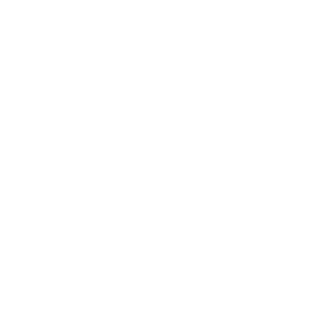

In [14]:
plt.figure(figsize=(4, 4))
plt.imshow(x_train[0])
plt.axis("off")

In [15]:
print(type(x_train[0]))


<class 'numpy.ndarray'>


In [16]:
(x_train), (y_train) = (
    np.asarray(images[: int(len(images) * 0.8)]),
    np.asarray(targets[: int(len(targets) * 0.8)]),
)
(x_test), (y_test) = (
    np.asarray(images[int(len(images) * 0.8) :]),
    np.asarray(targets[int(len(targets) * 0.8) :]),
)
patches = Patches(patch_size)(tf.convert_to_tensor([x_train[0]]))

Metal device set to: Apple M1 Pro


2022-12-23 09:42:03.436033: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-23 09:42:03.437485: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [17]:
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"{patches.shape[1]} patches per image \n{patches.shape[-1]} elements per patch")

Image size: 224 X 224
Patch size: 32 X 32
49 patches per image 
3072 elements per patch


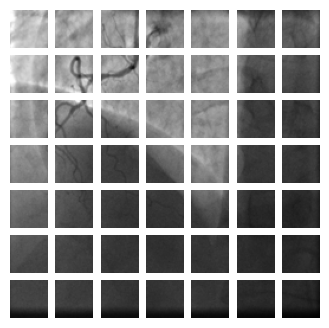

In [18]:
n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [19]:
x_train[1]

array([[[253., 253., 253.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [252., 252., 252.],
        [238., 238., 238.],
        [224., 224., 224.]],

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [254., 254., 254.],
        [237., 237., 237.],
        [226., 226., 226.]],

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [250., 250., 250.],
        [237., 237., 237.],
        [220., 220., 220.]],

       ...,

       [[ 16.,  16.,  16.],
        [ 21.,  21.,  21.],
        [ 22.,  22.,  22.],
        ...,
        [ 84.,  84.,  84.],
        [ 68.,  68.,  68.],
        [ 48.,  48.,  48.]],

       [[ 11.,  11.,  11.],
        [ 11.,  11.,  11.],
        [  8.,   8.,   8.],
        ...,
        [ 52.,  52.,  52.],
        [ 47.,  47.,  47.],
        [ 40.,  40.,  40.]],

       [[ 13.,  13.,  13.],
        [ 12.,  12.,  12.],
        [ 12.,  

In [20]:
patches = Patches(patch_size)(tf.convert_to_tensor([x_train[1]]))
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"{patches.shape[1]} patches per image \n{patches.shape[-1]} elements per patch")

Image size: 224 X 224
Patch size: 32 X 32
49 patches per image 
3072 elements per patch


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

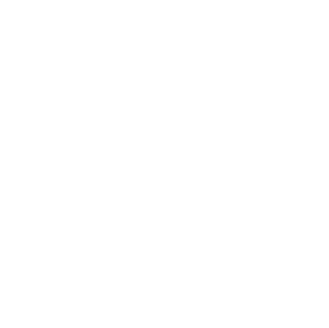

In [21]:
n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy())
    plt.axis("off")

In [22]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def get_config(self):
        config = super().get_config().copy()
        config.update(
            {
                "input_shape": input_shape,
                "patch_size": patch_size,
                "num_patches": num_patches,
                "projection_dim": projection_dim,
                "num_heads": num_heads,
                "transformer_units": transformer_units,
                "transformer_layers": transformer_layers,
                "mlp_head_units": mlp_head_units,
            }
        )
        return config

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded


In [23]:
def create_vit_object_detector(
    input_shape,
    patch_size,
    num_patches,
    projection_dim,
    num_heads,
    transformer_units,
    transformer_layers,
    mlp_head_units,
):
    inputs = layers.Input(shape=input_shape)
    patches = Patches(patch_size)(inputs)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    for _ in range(transformer_layers):
        #  normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        x2 = layers.Add()([attention_output, encoded_patches])
        #  normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        #  connection 2.
        encoded_patches = layers.Add()([x3, x2])

    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.3)(representation)
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.3)

    bounding_box = layers.Dense(4)(
        features
    ) 

    return keras.Model(inputs=inputs, outputs=bounding_box)

In [24]:
def run_experiment(model, learning_rate, weight_decay, batch_size, num_epochs):

    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(optimizer=optimizer, loss=keras.losses.MeanSquaredError())

    checkpoint_filepath = "logs/"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[
            checkpoint_callback,
            keras.callbacks.EarlyStopping(monitor="val_loss", patience=10),
        ],
    )

    return history

In [25]:
input_shape = (image_size, image_size, 3) 
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 32
num_epochs = 100
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]
transformer_layers = 4
mlp_head_units = [2048, 1024, 512, 64, 32]  


history = []
num_patches = (image_size // patch_size) ** 2

vit_object_detector = create_vit_object_detector(
    input_shape,
    patch_size,
    num_patches,
    projection_dim,
    num_heads,
    transformer_units,
    transformer_layers,
    mlp_head_units,
)

In [26]:
history = run_experiment(
    vit_object_detector, learning_rate, weight_decay, batch_size, num_epochs
)

Epoch 1/100


2022-12-23 09:42:08.431144: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-23 09:42:11.006233: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


169/169 [==============================] - ETA: 0s - loss: 0.1149

2022-12-23 09:42:44.449980: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


169/169 [==============================] - 39s 202ms/step - loss: 0.1149 - val_loss: 0.0606
Epoch 2/100
169/169 [==============================] - 33s 196ms/step - loss: 0.0311 - val_loss: 0.0406
Epoch 3/100
169/169 [==============================] - 751s 4s/step - loss: 0.0259 - val_loss: 0.0302
Epoch 4/100
169/169 [==============================] - 37s 218ms/step - loss: 0.0240 - val_loss: 0.0350
Epoch 5/100
169/169 [==============================] - 36s 211ms/step - loss: 0.0235 - val_loss: 0.0304
Epoch 6/100
169/169 [==============================] - 35s 205ms/step - loss: 0.0230 - val_loss: 0.0262
Epoch 7/100
169/169 [==============================] - 37s 221ms/step - loss: 0.0229 - val_loss: 0.0267
Epoch 8/100
169/169 [==============================] - 38s 226ms/step - loss: 0.0227 - val_loss: 0.0261
Epoch 9/100
169/169 [==============================] - 39s 232ms/step - loss: 0.0226 - val_loss: 0.0250
Epoch 10/100
169/169 [==============================] - 41s 240ms/step - loss: